In [1]:
! pip install -q kaggle
! pip install resampy
from google.colab import files

files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.8 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
! kaggle datasets download -d ejlok1/cremad
! kaggle datasets download -d pukung375/speech-emotion-recognition-with-cnn
! kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
! kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

100% 429M/429M [00:17<00:00, 26.7MB/s]
100% 429M/429M [00:17<00:00, 26.3MB/s]
 99% 449M/451M [00:19<00:00, 27.7MB/s]
100% 451M/451M [00:19<00:00, 24.2MB/s]
 88% 11.0M/12.4M [00:01<00:00, 15.3MB/s]
100% 12.4M/12.4M [00:01<00:00, 10.7MB/s]
100% 107M/107M [00:05<00:00, 22.1MB/s]
100% 107M/107M [00:05<00:00, 19.0MB/s]
100% 428M/428M [00:21<00:00, 22.5MB/s]
100% 428M/428M [00:21<00:00, 20.4MB/s]


In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
! unzip /content/cremad.zip
! unzip /content/ravdess-emotional-speech-audio.zip
! unzip /content/speech-emotion-recognition-with-cnn.zip
! unzip /content/surrey-audiovisual-expressed-emotion-savee.zip
! unzip /content/toronto-emotional-speech-set-tess.zip

In [5]:
TESS = "tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "audio_speech_actors_01-24/"
SAVEE = "ALL/"
CREMA = "AudioWAV/"

# Run one example 
dir_list = os.listdir(SAVEE)
dir_list[0:5]

['KL_h09.wav', 'DC_n29.wav', 'JE_d14.wav', 'KL_a15.wav', 'JK_su14.wav']

In [6]:
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)

# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_happy        60
male_disgust      60
male_angry        60
male_surprise     60
male_sad          60
male_fear         60
Name: labels, dtype: int64

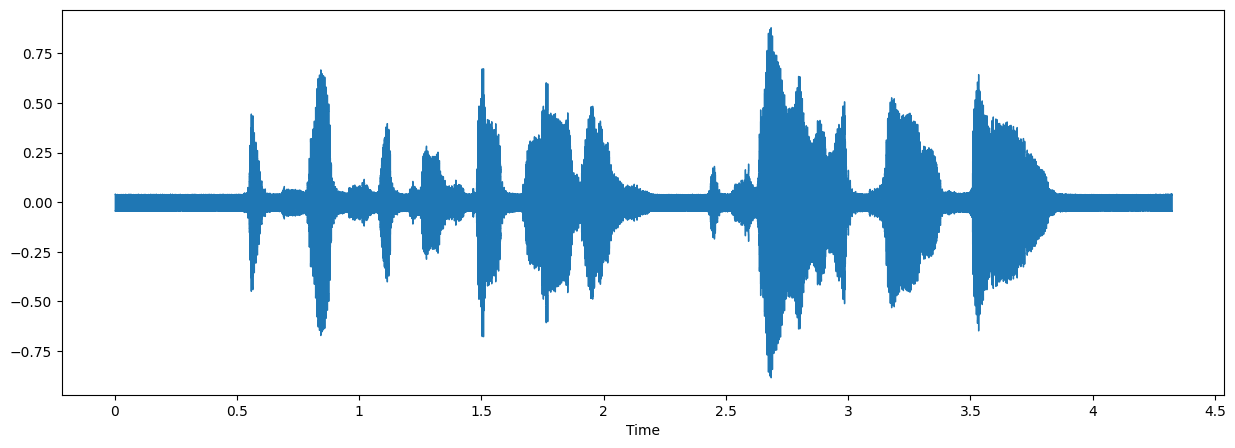

In [7]:
# use the well known Librosa library for this task 
fname = SAVEE + 'DC_f11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

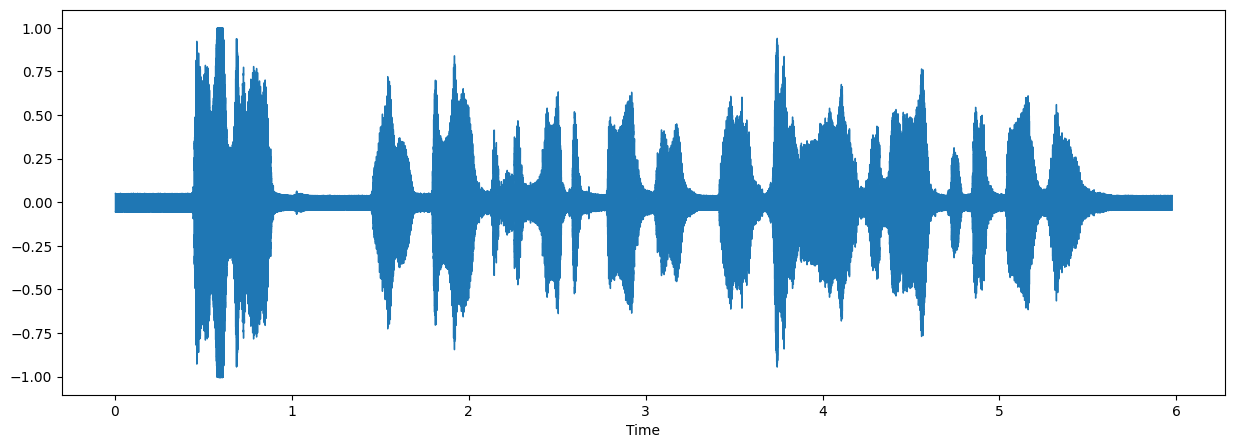

In [8]:
# Lets play a happy track
fname = SAVEE + 'DC_h11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [9]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_disgust        96
male_angry          96
male_fear           96
male_surprise       96
male_happy          96
male_sad            96
female_fear         96
female_angry        96
female_disgust      96
female_happy        96
female_surprise     96
female_sad          96
Name: labels, dtype: int64

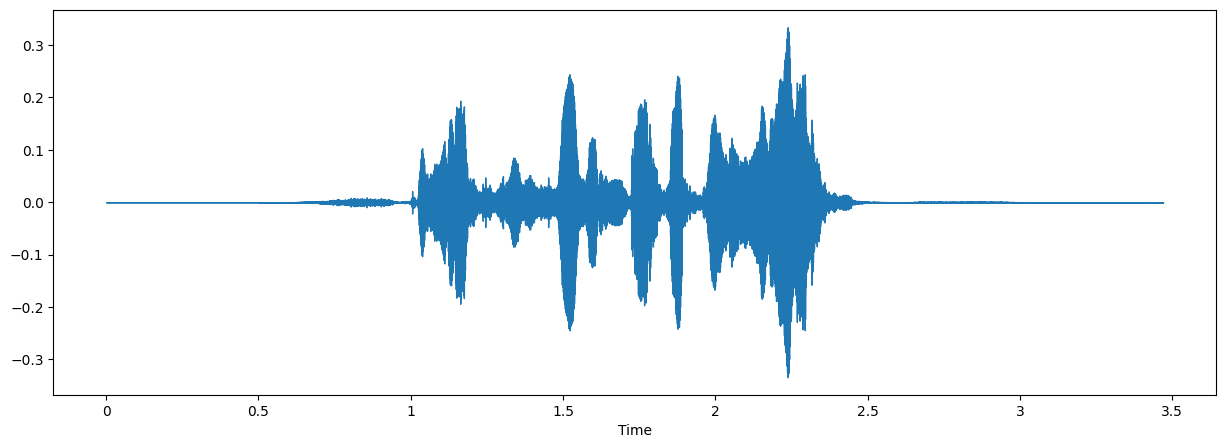

In [10]:
# Pick a fearful track
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

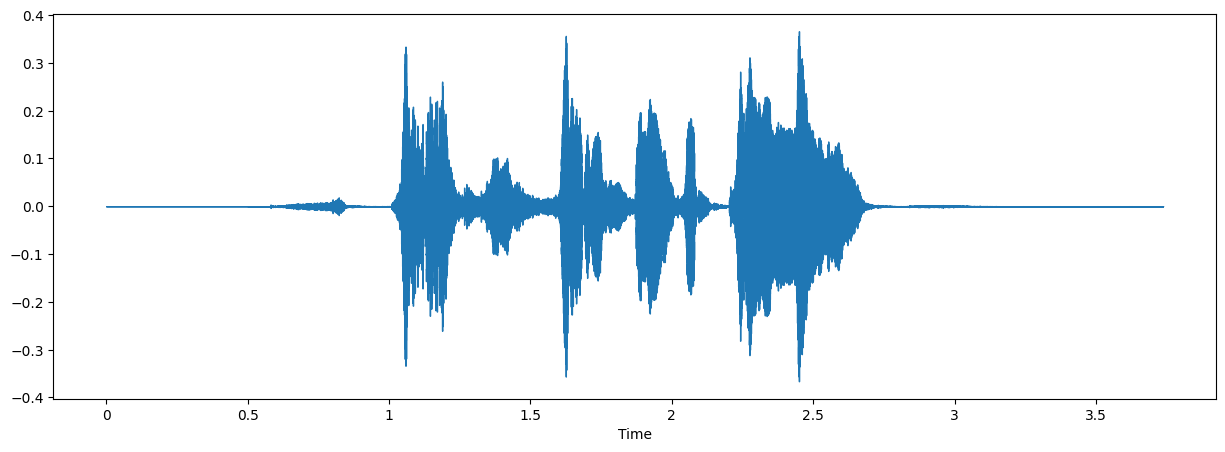

In [11]:
# Pick a happy track
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [12]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [13]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_fear        400
female_surprise    400
female_sad         400
female_angry       400
female_disgust     400
female_happy       400
female_neutral     400
Name: labels, dtype: int64

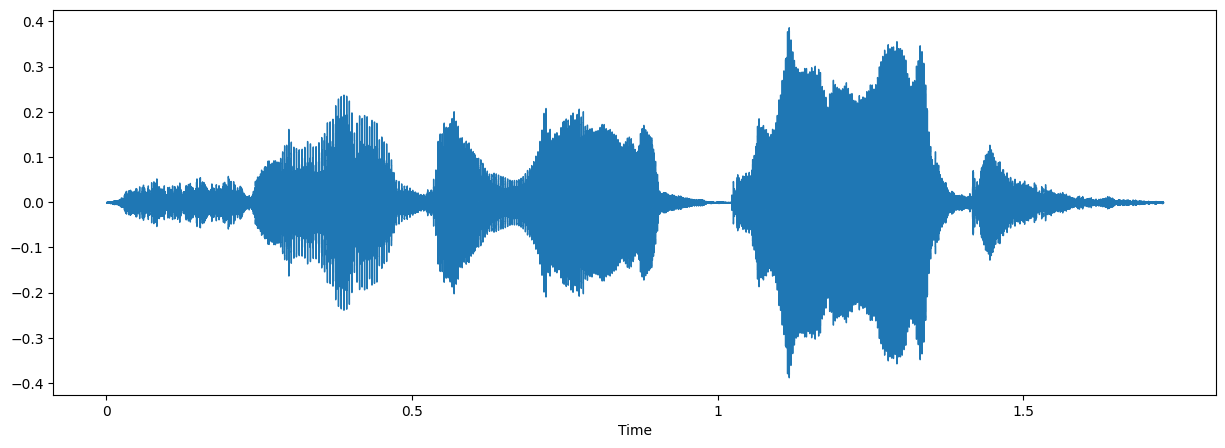

In [14]:
# lets play a fearful track 
fname = TESS + 'YAF_fear/YAF_dog_fear.wav' 

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

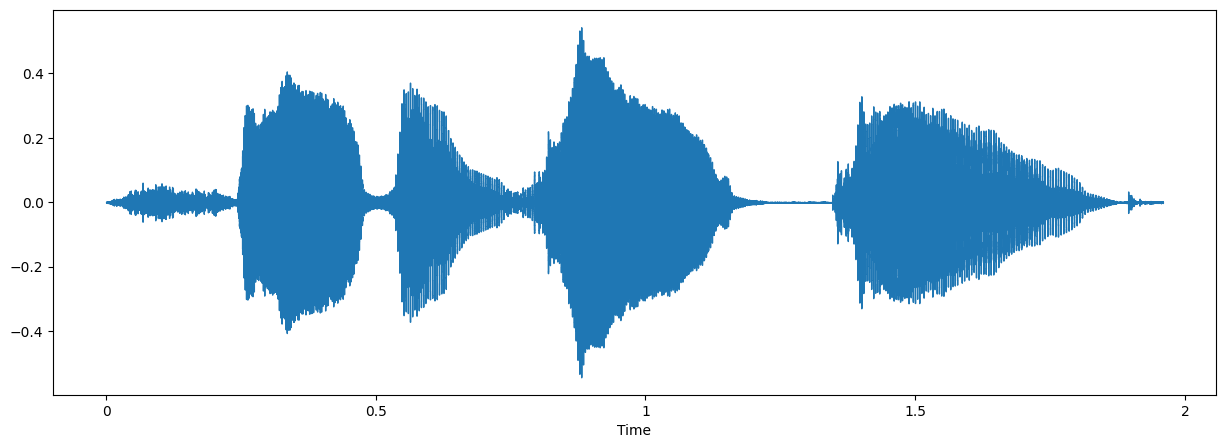

In [15]:
# lets play a happy track 
fname =  TESS + 'YAF_happy/YAF_dog_happy.wav' 

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [16]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [17]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

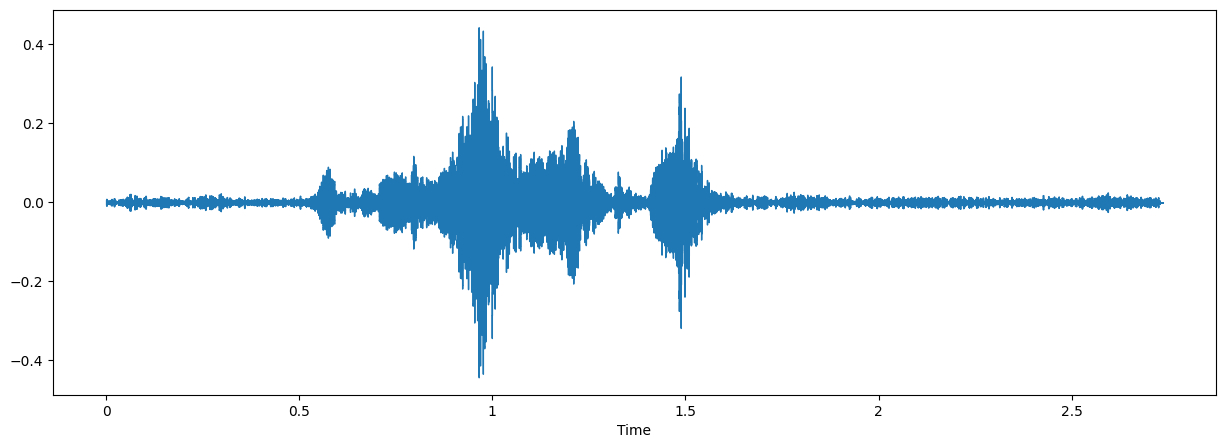

In [18]:
# use the well known Librosa library for this task 
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

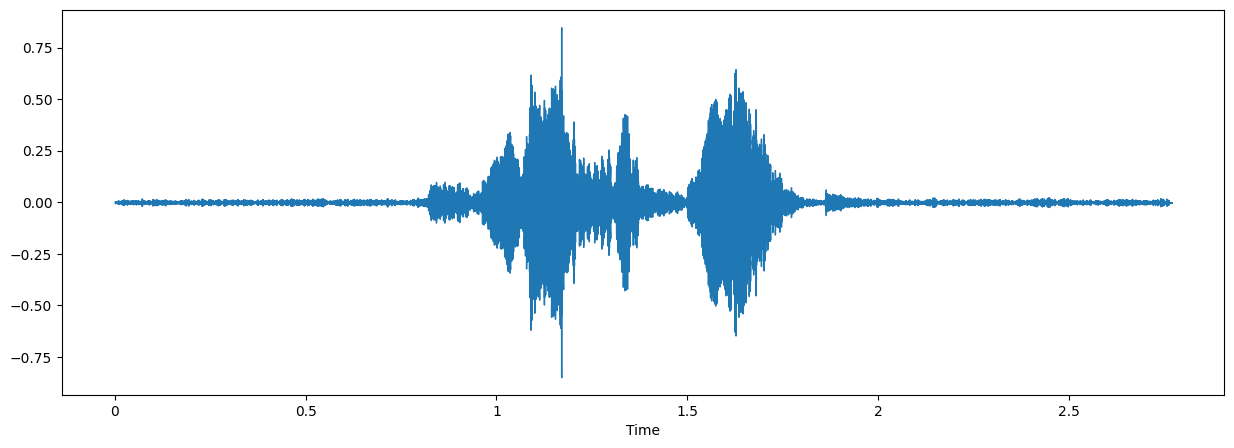

In [19]:
# A fearful track
fname = CREMA + '1012_IEO_FEA_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [20]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_fear        1096
female_angry       1096
female_disgust     1096
female_happy       1096
female_sad         1096
female_neutral     1056
male_neutral        839
male_happy          827
male_disgust        827
male_angry          827
male_sad            827
male_fear           827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64


In [21]:
# Import our libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import os
import IPython.display as ipd  # To play sound in the notebook

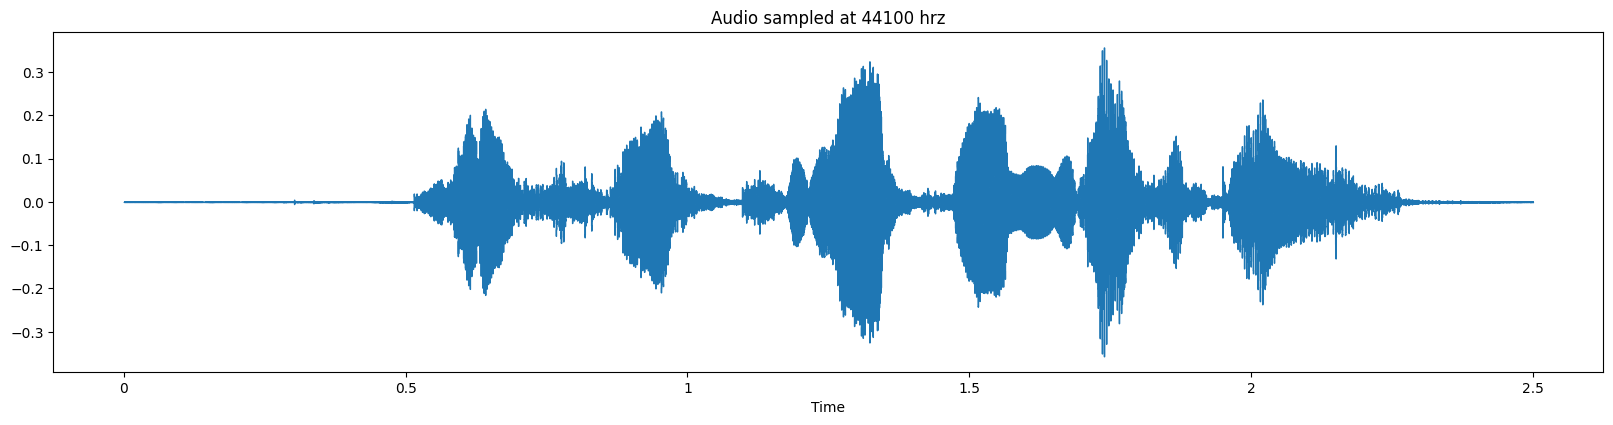

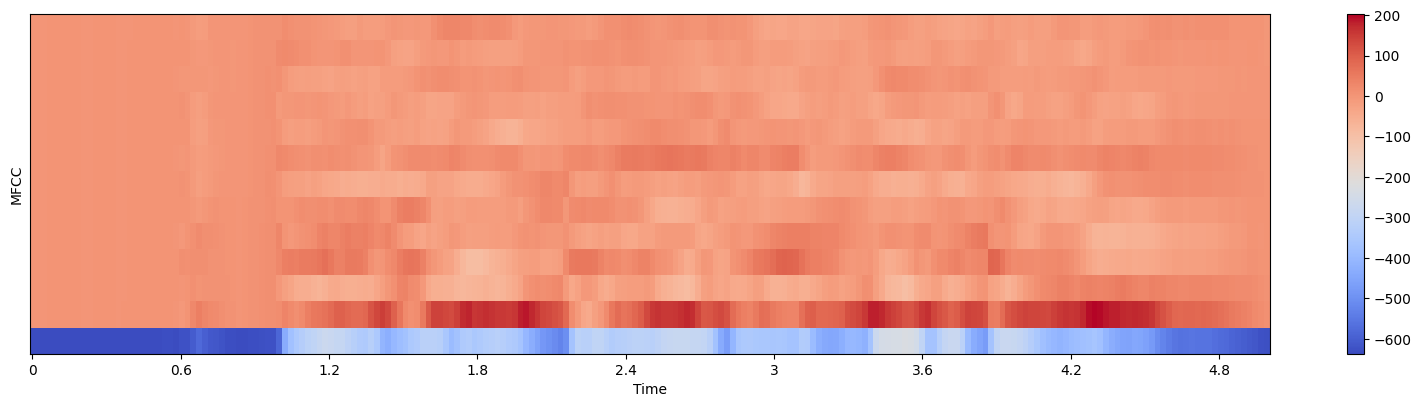

In [22]:
path = "audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

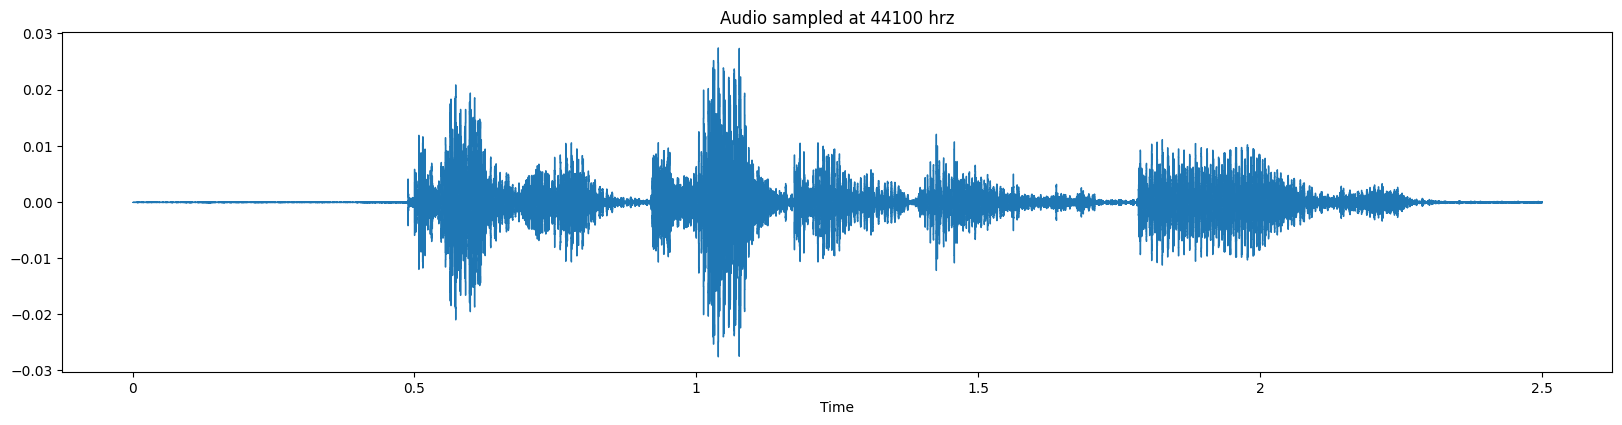

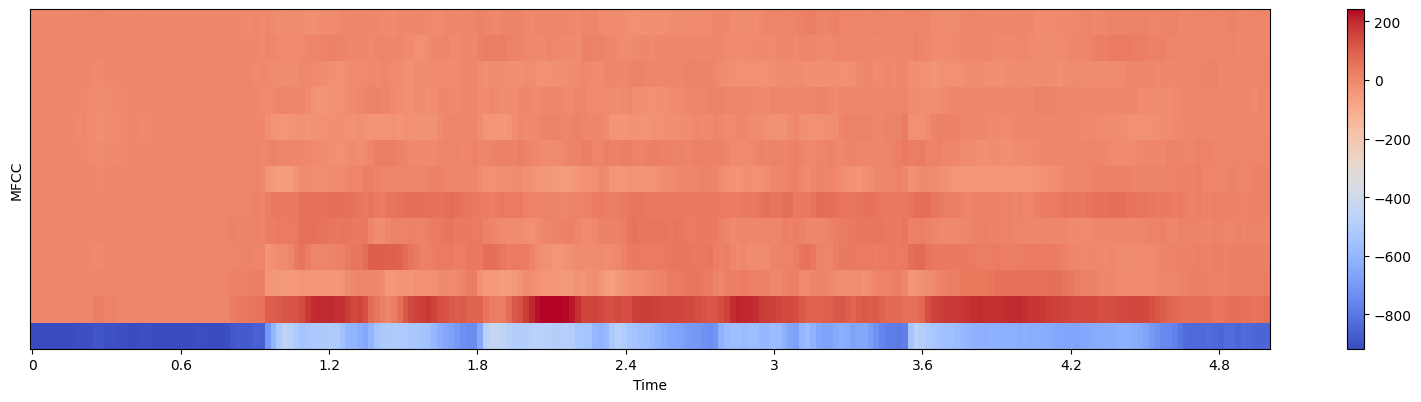

In [23]:
path = "audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

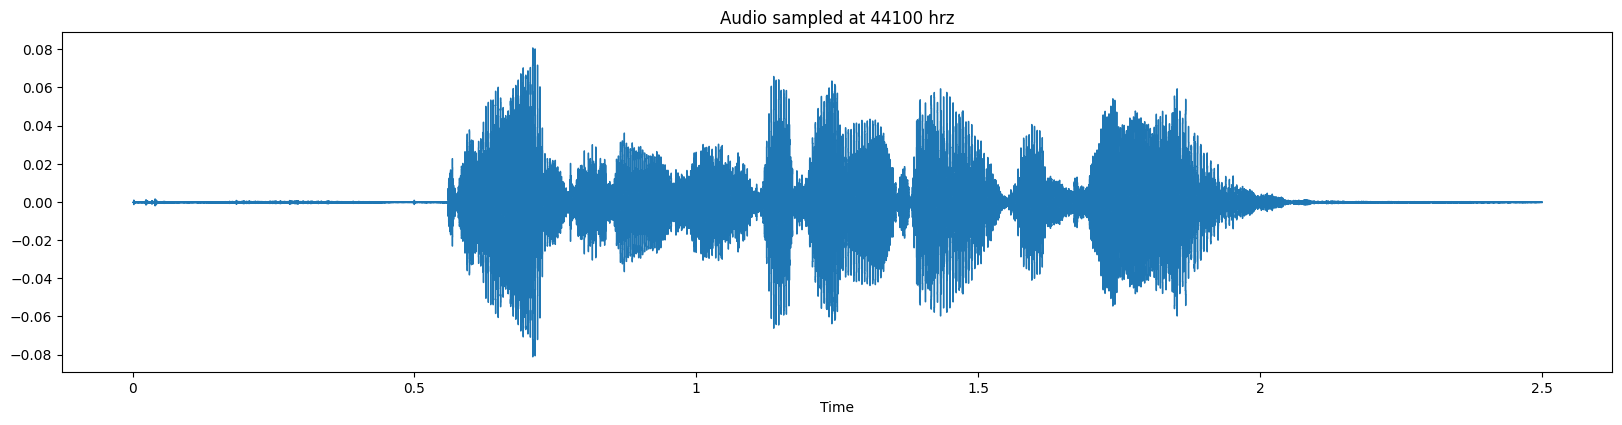

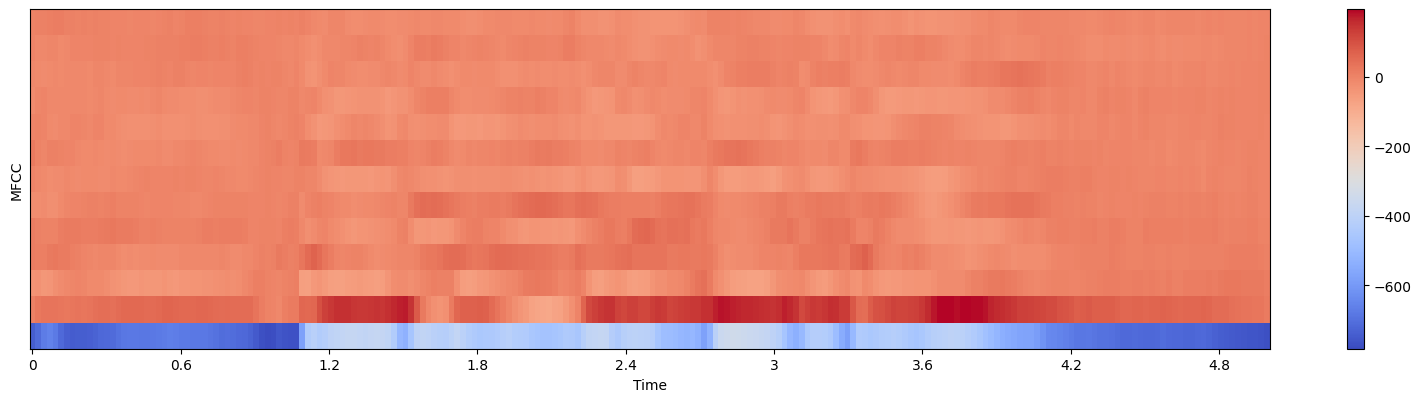

In [24]:
path = "audio_speech_actors_01-24/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

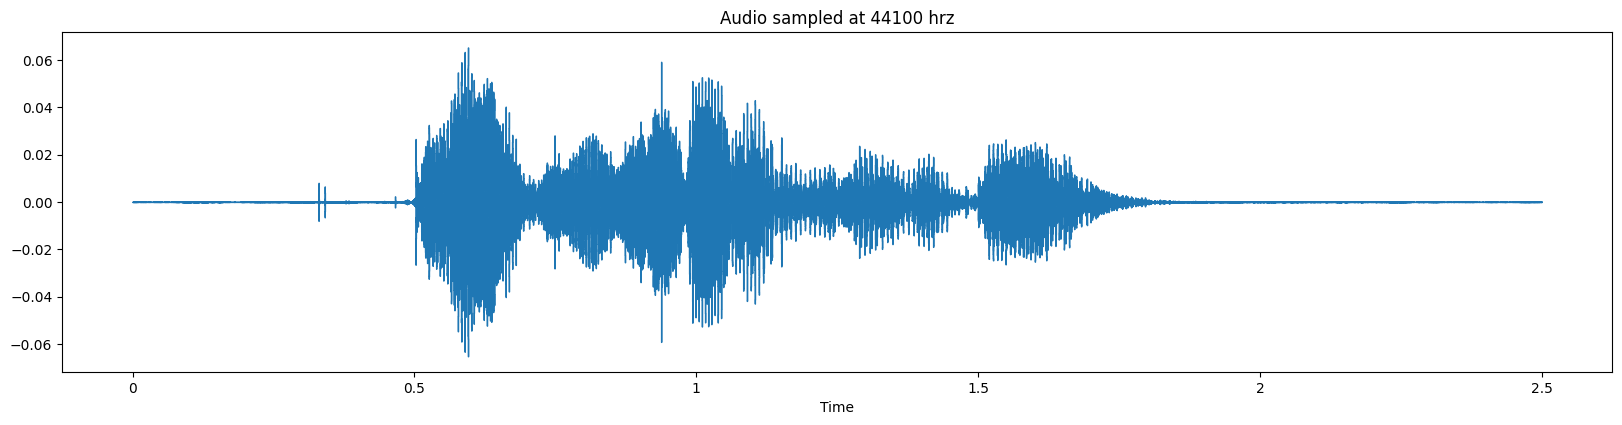

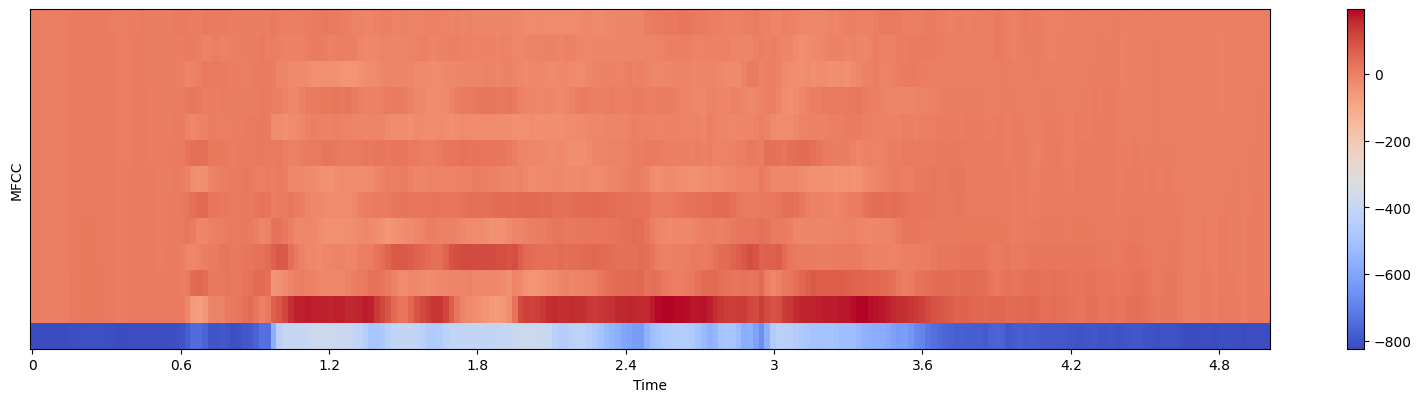

In [25]:
# Source - RAVDESS; Gender - Male; Emotion - Happy 
path = "audio_speech_actors_01-24/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

216
216


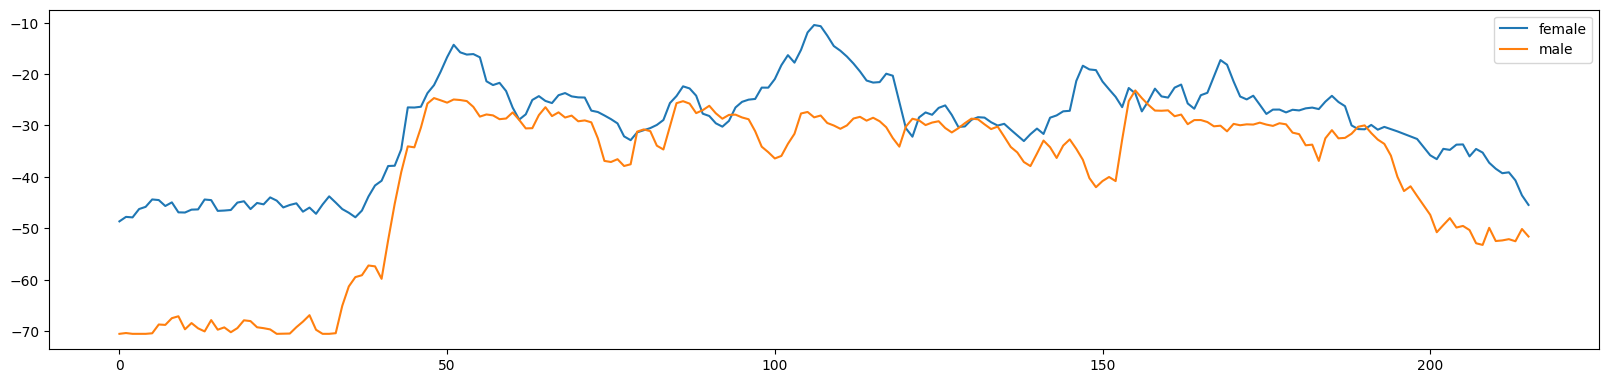

In [26]:
path = "audio_speech_actors_01-24/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "audio_speech_actors_01-24/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

216
216


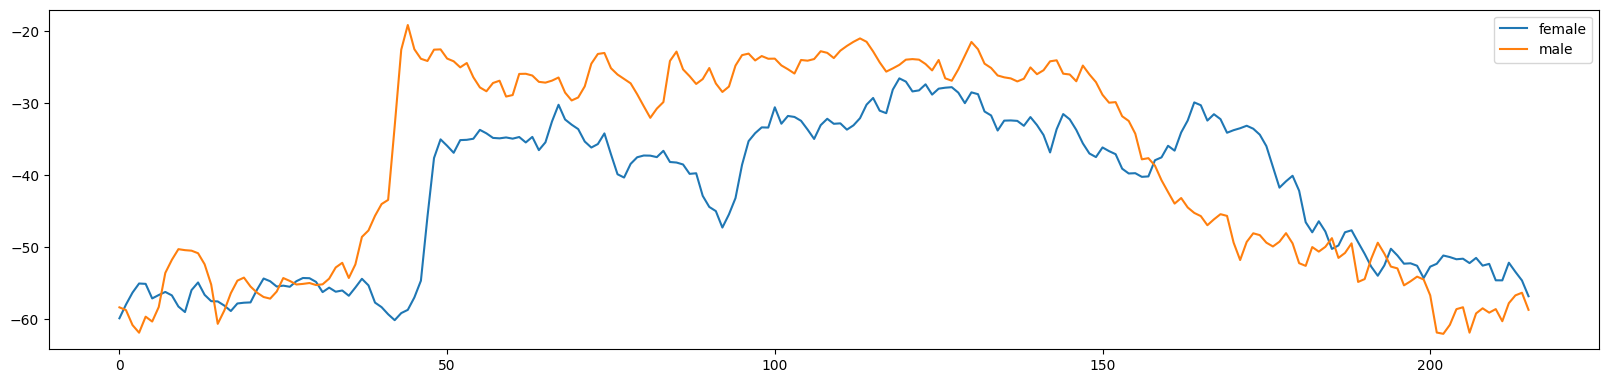

In [27]:
path = "audio_speech_actors_01-24/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - happy 
path = "audio_speech_actors_01-24/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [28]:
! pip3 install keras_preprocessing
import tensorflow.keras as keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [29]:
ref = pd.read_csv("Data_path.csv")
ref.head()

labels source             path
0     male_happy  SAVEE   ALL/KL_h09.wav
1   male_neutral  SAVEE   ALL/DC_n29.wav
2   male_disgust  SAVEE   ALL/JE_d14.wav
3     male_angry  SAVEE   ALL/KL_a15.wav
4  male_surprise  SAVEE  ALL/JK_su14.wav

In [30]:
# Create an empty DataFrame
df = pd.DataFrame(columns=['feature'])

# Loop over the entire dataset
counter = 0
for index, path in enumerate(ref.path):
    if not os.path.isdir(path):  # Skip directories
        X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=2.5, sr=44100, offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        df.loc[counter] = [mfccs]
        counter += 1

# Check the number of processed records
print(len(df))

# Display the first few records
df.head()

12162


feature
0  [-12.911234, -15.995853, -26.250223, -25.75496...
1  [-5.0955143, -6.505261, -7.5535083, -7.057322,...
2  [-9.084726, -13.519837, -28.964285, -26.39315,...
3  [-17.74597, -18.884546, -23.42749, -22.7608, -...
4  [-15.006602, -17.96914, -22.142754, -23.360626...

In [31]:
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

labels source             path          0          1          2  \
0     male_happy  SAVEE   ALL/KL_h09.wav -12.911234 -15.995853 -26.250223   
1   male_neutral  SAVEE   ALL/DC_n29.wav  -5.095514  -6.505261  -7.553508   
2   male_disgust  SAVEE   ALL/JE_d14.wav  -9.084726 -13.519837 -28.964285   
3     male_angry  SAVEE   ALL/KL_a15.wav -17.745970 -18.884546 -23.427490   
4  male_surprise  SAVEE  ALL/JK_su14.wav -15.006602 -17.969139 -22.142754   

           3          4          5          6  ...        206        207  \
0 -25.754965 -26.750675 -29.208357 -30.564640  ... -39.329136 -40.033535   
1  -7.057322  -9.294626 -10.950762 -10.996920  ... -23.246267 -21.663572   
2 -26.393150 -26.629728 -26.182613 -27.186934  ...  -6.801298  -9.773386   
3 -22.760799 -23.077982 -22.940372 -22.521370  ... -40.074909 -30.090427   
4 -23.360626 -23.179911 -24.432413 -23.724516  ... -21.367159 -21.316824   

         208        209        210        211        212        213  \
0 -39.553448 -40.625351 -41.946110 -40.557064 -39.921272 -39.770309   
1 -20.921837 -23.624075 -27.310678 -24.046165 -24.186642 -25.714201   
2 -14.412579 -16.334576 -17.786877 -12.155889  -7.309869  -5.794612   
3 -25.397209 -24.566366 -25.313774 -27.188734 -27.189817 -26.741159   
4 -19.313728 -17.488432 -19.438925 -18.876432 -17.936892 -17.562813   

         214        215  
0 -37.602703 -32.497417  
1 -17.385746  -9.068009  
2  -5.497773  -6.081780  
3 -23.643198 -19.852413  
4  -7.980640  -1.854176  

[5 rows x 219 columns]

In [32]:
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


labels source             path          0          1          2  \
0     male_happy  SAVEE   ALL/KL_h09.wav -12.911234 -15.995853 -26.250223   
1   male_neutral  SAVEE   ALL/DC_n29.wav  -5.095514  -6.505261  -7.553508   
2   male_disgust  SAVEE   ALL/JE_d14.wav  -9.084726 -13.519837 -28.964285   
3     male_angry  SAVEE   ALL/KL_a15.wav -17.745970 -18.884546 -23.427490   
4  male_surprise  SAVEE  ALL/JK_su14.wav -15.006602 -17.969139 -22.142754   

           3          4          5          6  ...        206        207  \
0 -25.754965 -26.750675 -29.208357 -30.564640  ... -39.329136 -40.033535   
1  -7.057322  -9.294626 -10.950762 -10.996920  ... -23.246267 -21.663572   
2 -26.393150 -26.629728 -26.182613 -27.186934  ...  -6.801298  -9.773386   
3 -22.760799 -23.077982 -22.940372 -22.521370  ... -40.074909 -30.090427   
4 -23.360626 -23.179911 -24.432413 -23.724516  ... -21.367159 -21.316824   

         208        209        210        211        212        213  \
0 -39.553448 -40.625351 -41.946110 -40.557064 -39.921272 -39.770309   
1 -20.921837 -23.624075 -27.310678 -24.046165 -24.186642 -25.714201   
2 -14.412579 -16.334576 -17.786877 -12.155889  -7.309869  -5.794612   
3 -25.397209 -24.566366 -25.313774 -27.188734 -27.189817 -26.741159   
4 -19.313728 -17.488432 -19.438925 -18.876432 -17.936892 -17.562813   

         214        215  
0 -37.602703 -32.497417  
1 -17.385746  -9.068009  
2  -5.497773  -6.081780  
3 -23.643198 -19.852413  
4  -7.980640  -1.854176  

[5 rows x 219 columns]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]
y_train.shape

(9121,)

In [34]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

0         1         2         3         4         5         6    \
4950   0.372801  0.350491  0.435824  0.386116  0.495900  0.539613  0.458245   
3860   0.185935  0.357874  0.712715  0.638444  0.242457 -0.030657 -0.145043   
9761   1.262240  1.177296  1.087939  0.899445  1.043044  0.894358  0.731580   
7620   1.102853  1.310437  1.462517  1.356461  1.391153  1.297714  1.164792   
11586 -0.018760  0.016808  0.275195  0.258754  0.214732  0.401937  0.405653   
7914   0.160581  0.222492  0.536491  0.534446  0.350388  0.331389  0.142867   
9513   0.159028  0.248829  0.602804  0.535517  0.434415  0.433263  0.344562   
5835   0.088659  0.245425  0.486953  0.455597  0.432855  0.394283  0.539894   
5389  -0.028973  0.135455  0.394212  0.350473  0.354589  0.435030  0.431016   
11222  0.165905  0.321627  0.374729  0.424052  0.483091  0.457843  0.443565   

            7         8         9    ...       206       207       208  \
4950   0.429271  0.432965  0.578708  ... -0.883892 -0.816341 -0.696603   
3860  -0.153861 -0.109902  0.205838  ...  0.540236  0.526489  0.526125   
9761   0.758166  0.718258  0.634654  ...  0.540236  0.526489  0.526125   
7620   1.082318  1.113939  1.145327  ...  0.540236  0.526489  0.526125   
11586  0.565036  0.703522  0.634338  ...  0.540236  0.526489  0.526125   
7914   0.272933  0.428730  0.326738  ...  0.540236  0.526489  0.526125   
9513   0.404211  0.505072  0.522730  ... -0.571448 -0.676113 -0.574099   
5835   0.445832  0.425966  0.435475  ...  0.540236  0.526489  0.526125   
5389   0.292432  0.212147  0.336045  ...  0.540236  0.526489  0.526125   
11222  0.242641  0.382849  0.572920  ... -0.582827 -0.598085 -0.690762   

            209       210       211       212       213       214       215  
4950  -0.634597 -0.680327 -0.722355 -0.865822 -0.989940 -0.975698 -0.920477  
3860   0.526716  0.511901  0.511684  0.512491  0.500837  0.494216  0.487163  
9761   0.526716  0.511901  0.511684  0.512491  0.500837  0.494216  0.487163  
7620   0.526716  0.511901  0.511684  0.512491  0.500837  0.494216  0.487163  
11586  0.526716  0.511901  0.511684  0.512491  0.500837  0.494216  0.487163  
7914   0.526716  0.511901  0.511684  0.512491  0.500837  0.494216  0.487163  
9513  -0.652559  0.511901  0.511684  0.512491  0.500837  0.494216  0.487163  
5835   0.526716  0.511901  0.511684  0.512491  0.500837  0.494216  0.487163  
5389   0.526716  0.511901  0.511684  0.512491  0.500837  0.494216  0.487163  
11222 -0.749350 -0.734245 -0.612053 -0.433146 -0.559325 -0.546319 -0.671991  

[10 rows x 216 columns]

In [35]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import pickle

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Convert target values to 1D array
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

# One-hot encode the target values
lb = LabelEncoder()
y_train_encoded = np_utils.to_categorical(lb.fit_transform(y_train_flat))
y_test_encoded = np_utils.to_categorical(lb.transform(y_test_flat))

# Print the shapes and classes
print(X_train.shape)
print(lb.classes_)
print(y_test_encoded)

# Pickle the label encoder for future use
filename = 'labels.pkl'
with open(filename, 'wb') as outfile:
    pickle.dump(lb, outfile)


(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [36]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

In [39]:
import tensorflow
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = tf.keras.optimizers.RMSprop(lr=0.00001)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 216, 256)          2304      
                                                                 
 activation_9 (Activation)   (None, 216, 256)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 batch_normalization_2 (Batc  (None, 216, 256)         1024      
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 216, 256)          0         
                                                                 
 dropout_2 (Dropout)         (None, 216, 256)          0         
                                                      

In [40]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_history = model.fit(X_train, y_train_encoded, batch_size=16, epochs=100, validation_data=(X_test, y_test_encoded))

Epoch 1/100
571/571 [==============================] - 23s 12ms/step - loss: 2.2031 - accuracy: 0.2151 - val_loss: 2.1721 - val_accuracy: 0.2331
Epoch 2/100
571/571 [==============================] - 7s 12ms/step - loss: 2.0158 - accuracy: 0.2625 - val_loss: 2.2532 - val_accuracy: 0.1815
Epoch 3/100
571/571 [==============================] - 7s 12ms/step - loss: 1.9341 - accuracy: 0.3076 - val_loss: 1.9536 - val_accuracy: 0.3085
Epoch 4/100
571/571 [==============================] - 6s 11ms/step - loss: 1.8516 - accuracy: 0.3370 - val_loss: 1.9577 - val_accuracy: 0.2976
Epoch 5/100
571/571 [==============================] - 7s 12ms/step - loss: 1.8046 - accuracy: 0.3552 - val_loss: 2.0663 - val_accuracy: 0.2841
Epoch 6/100
571/571 [==============================] - 7s 12ms/step - loss: 1.7636 - accuracy: 0.3752 - val_loss: 1.9389 - val_accuracy: 0.3131
Epoch 7/100
571/571 [==============================] - 7s 12ms/step - loss: 1.7367 - accuracy: 0.3848 - val_loss: 1.8610 - val_accuracy

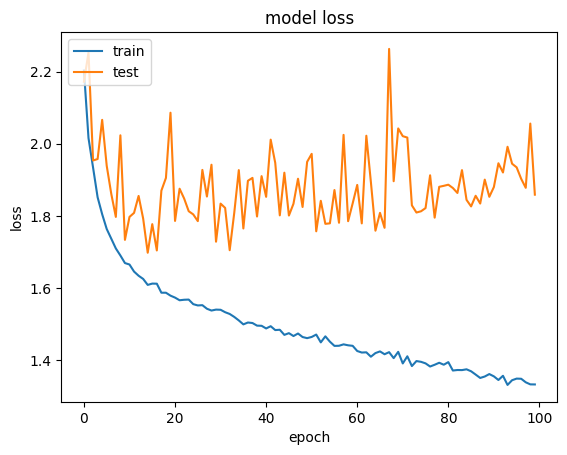

In [41]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model.h5 


In [47]:
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test_encoded, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 36.90%


In [66]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 1s 3ms/step


array([2, 3, 8, ..., 9, 4, 1])

In [67]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test_encoded.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

actualvalues  predictedvalues
170        male_sad   female_neutral
171    female_angry  female_surprise
172      male_angry       male_angry
173  female_disgust        male_fear
174      male_angry       male_angry
175     female_fear     female_happy
176    male_disgust       male_angry
177     female_fear   female_neutral
178    female_happy   female_neutral
179  female_neutral   female_neutral

In [68]:
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
female_angry              354
female_disgust            272
female_fear               273
female_happy              335
female_neutral            437
female_sad                367
female_surprise           219
male_angry                208
male_disgust               34
male_fear                  99
male_happy                 28
male_neutral              310
male_sad                   51
male_surprise              54

In [69]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.3689575797435054


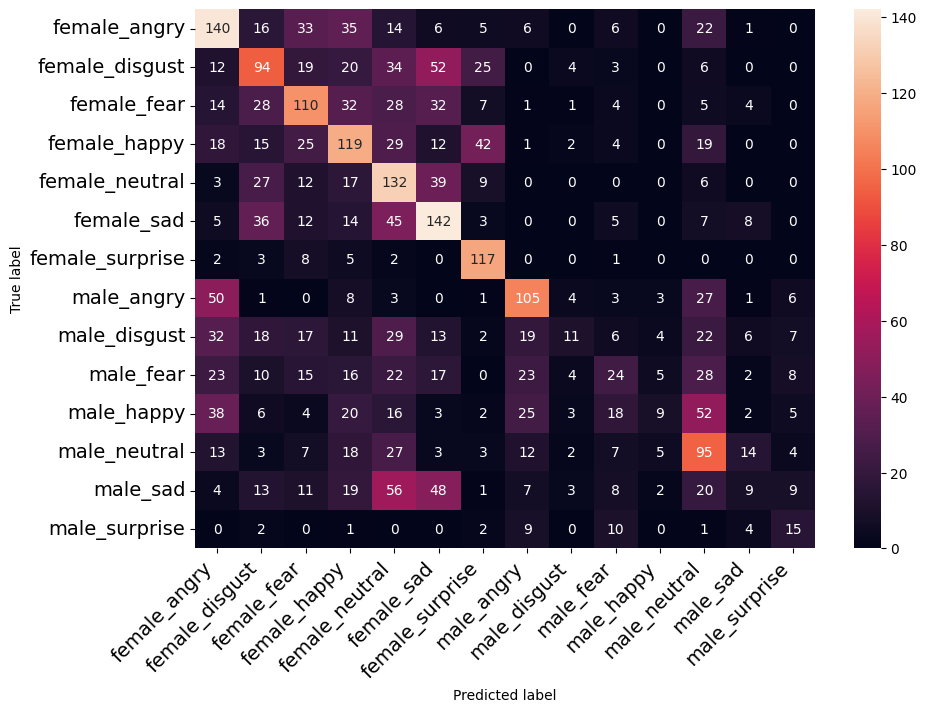

In [70]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [71]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.40      0.49      0.44       284
 female_disgust       0.35      0.35      0.35       269
    female_fear       0.40      0.41      0.41       266
   female_happy       0.36      0.42      0.38       286
 female_neutral       0.30      0.54      0.39       245
     female_sad       0.39      0.51      0.44       277
female_surprise       0.53      0.85      0.66       138
     male_angry       0.50      0.50      0.50       212
   male_disgust       0.32      0.06      0.10       197
      male_fear       0.24      0.12      0.16       197
     male_happy       0.32      0.04      0.08       203
   male_neutral       0.31      0.45      0.36       213
       male_sad       0.18      0.04      0.07       210
  male_surprise       0.28      0.34      0.31        44

       accuracy                           0.37      3041
      macro avg       0.35      0.37      0.33      3041
   weighted avg       0.35   

0.761920420914173


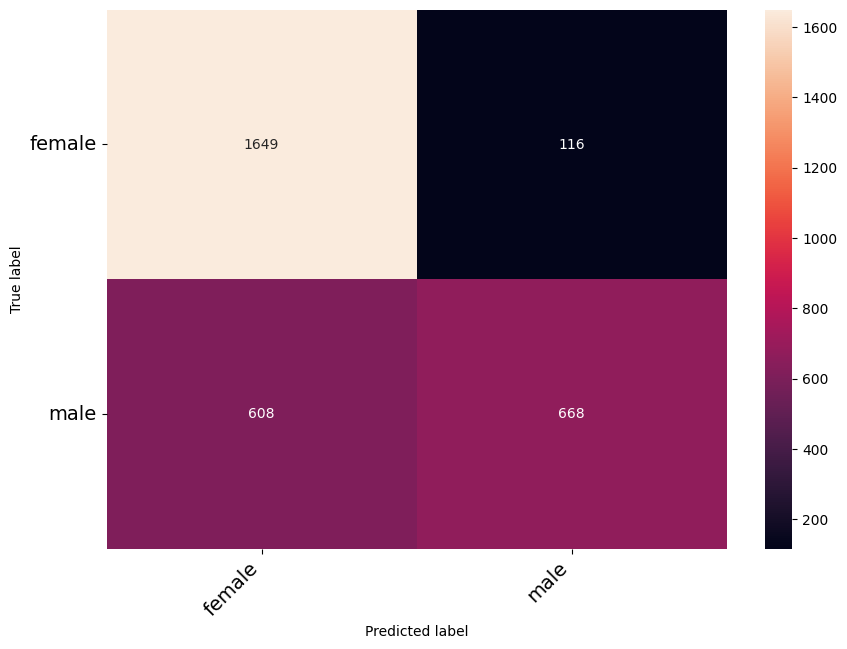

In [72]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [73]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.73      0.93      0.82      1765
        male       0.85      0.52      0.65      1276

    accuracy                           0.76      3041
   macro avg       0.79      0.73      0.73      3041
weighted avg       0.78      0.76      0.75      3041



0.43735613285103586


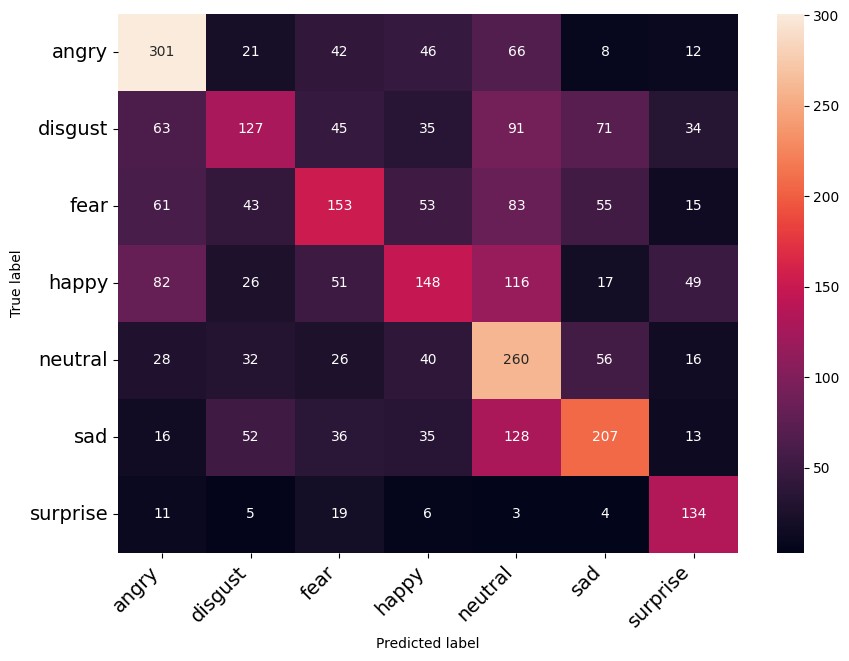

In [74]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [75]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.54      0.61      0.57       496
     disgust       0.42      0.27      0.33       466
        fear       0.41      0.33      0.37       463
       happy       0.41      0.30      0.35       489
     neutral       0.35      0.57      0.43       458
         sad       0.50      0.43      0.46       487
    surprise       0.49      0.74      0.59       182

    accuracy                           0.44      3041
   macro avg       0.44      0.46      0.44      3041
weighted avg       0.44      0.44      0.43      3041



In [76]:
from keras.models import Sequential, Model, model_from_json
import matplotlib.pyplot as plt
import keras 
import pickle
import wave  # !pip install wave
import os
import pandas as pd
import numpy as np
import sys
import warnings
import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [78]:
data, sampling_rate = librosa.load('AudioWAV/1001_IEO_HAP_HI.wav')
ipd.Audio('AudioWAV/1001_IEO_HAP_HI.wav')

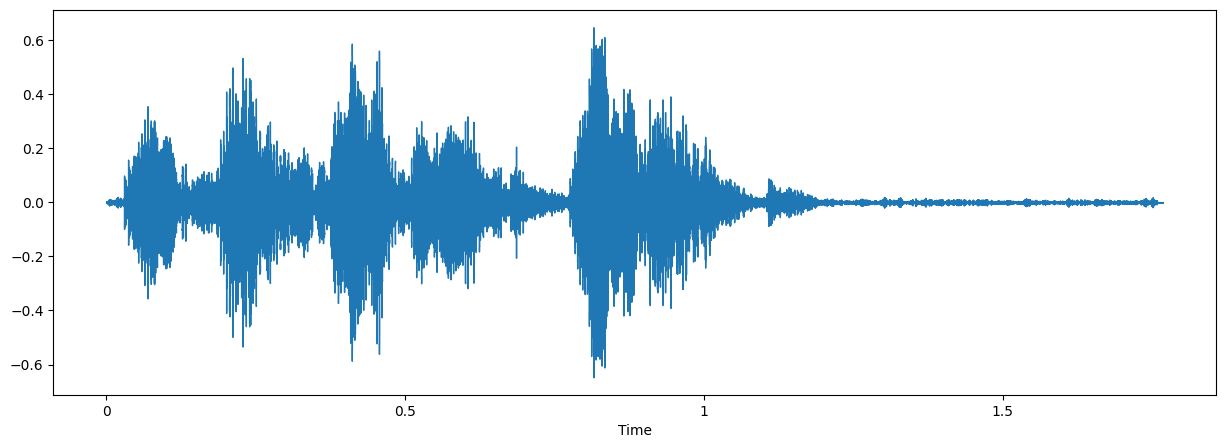

In [80]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [83]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")

# the optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test_encoded, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 36.90%
